# Test Data Analysis
Just messin around

In [1]:
# Install libraries
%pip install firebase_admin google-cloud-firestore pandas matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Firebase setup

import firebase_admin
from firebase_admin import credentials, firestore

cred = credentials.Certificate("secrets/firebase_key.json")
firebase_admin.initialize_app(cred)

db = firestore.client()

In [13]:
# Get user data

import firebase_admin
from firebase_admin import auth

email = "alexxander1611@gmail.com"

user = auth.get_user_by_email(email)
print(f'Successfully fetched user data: {user.uid}')

user_info = db.collection('Users').document(user.uid).get().to_dict()
print(user_info)


Successfully fetched user data: hiZJsylQKJNitULApBf4e9XH9vg1
{'uid': 'hiZJsylQKJNitULApBf4e9XH9vg1', 'email': 'Alexxander1611@gmail.com'}


## Collective Data

In [14]:

# Fetch collective data

import pandas as pd

imu_coll = db.collection('UserData').document(user.uid).collection('Sessions')
query = imu_coll.order_by("time", direction=firestore.Query.DESCENDING).limit(1)
user_imu = query.get()[0].to_dict()

rows = []

for device, device_data in user_imu['data'].items():
	for imu_function,data in device_data['imu'].items():
		segmentIdx = 0
		for segment in data.values():
			for entry in segment:
				for simd in entry['list']:
					entry = {}
					entry["Device"] = device
					entry['Type'] = imu_function 
					entry['Time'] = simd['readTime']
					entry['Segment'] = segmentIdx
					entry["X"] = simd['read'][0]
					entry["Y"] = simd['read'][1]
					entry["Z"] = simd['read'][2]
					entry['Timestamp'] = user_imu['time']
					rows.append(entry)
			segmentIdx += 1
	for segment in device_data['emg']['emg'].values():
		for entry in segment:
			for simd in entry['list']:
				entry = {}
				entry["Device"] = device
				entry['Type'] = 'emg' 
				entry['Time'] = simd['readTime']
				entry['Segment'] = segmentIdx
				entry["Value"] = simd['read']
				entry['Timestamp'] = user_imu['time']
				rows.append(entry)
		segmentIdx += 1
df = pd.DataFrame(rows)
df.head()

,Device,Type,Time,Segment,X,Y,Z,Timestamp
0,Alpha ,orientation,1.762556e+09,0,-0.046571,0.003678,0.018987,1.762556e+09
1,Alpha ,orientation,1.762556e+09,0,-0.046394,0.003746,0.018855,1.762556e+09
2,Alpha ,orientation,1.762556e+09,0,-0.046616,0.003816,0.018808,1.762556e+09
3,Alpha ,orientation,1.762556e+09,0,-0.046902,0.003733,0.018534,1.762556e+09
4,Alpha ,orientation,1.762556e+09,0,-0.046971,0.003814,0.018452,1.762556e+09


In [16]:
# Visualize IMU data of a given type

devname = "Alpha\x00"

gyro = df[df['Type'] == "gyro"].copy()
gyro = gyro[gyro['Device'] == devname]
earliest = gyro['Time'].min()
gyro['Elapsed'] = gyro['Time'] - earliest

planar = df[df['Type'] == "planar"].copy()
planar = planar[planar['Device'] == devname]
earliest = planar['Time'].min()
planar['Elapsed'] = planar['Time'] - earliest

mag = df[df['Type'] == "mag"].copy()
mag = mag[mag['Device'] == devname]
earliest = mag['Time'].min()
mag['Elapsed'] = mag['Time'] - earliest

emg = df[df['Type'] == "emg"].copy()
emg = emg[emg['Device'] == devname]
earliest = emg['Time'].min()
emg['Elapsed'] = emg['Time'] - earliest

orient = df[df['Type'] == "orientation"].copy()
orient = orient[orient['Device'] == devname]
earliest = orient['Time'].min()
orient['Elapsed'] = orient['Time'] - earliest

emg

,Device,Type,Time,Segment,X,Y,Z,Timestamp,Elapsed


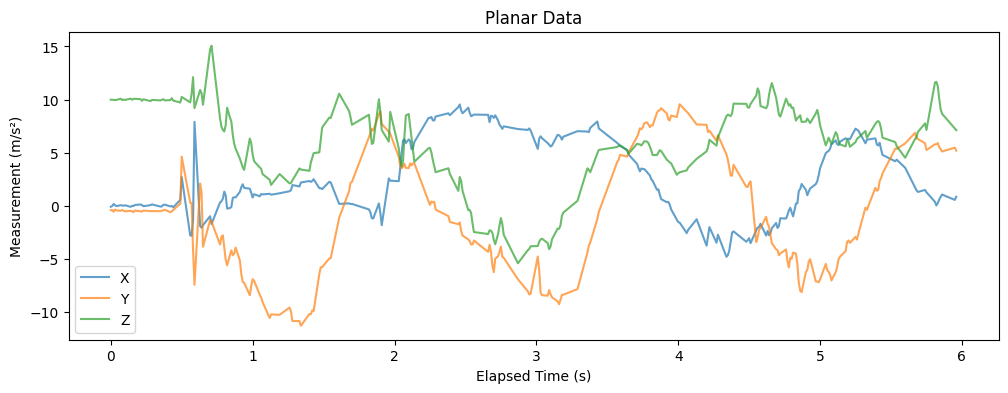

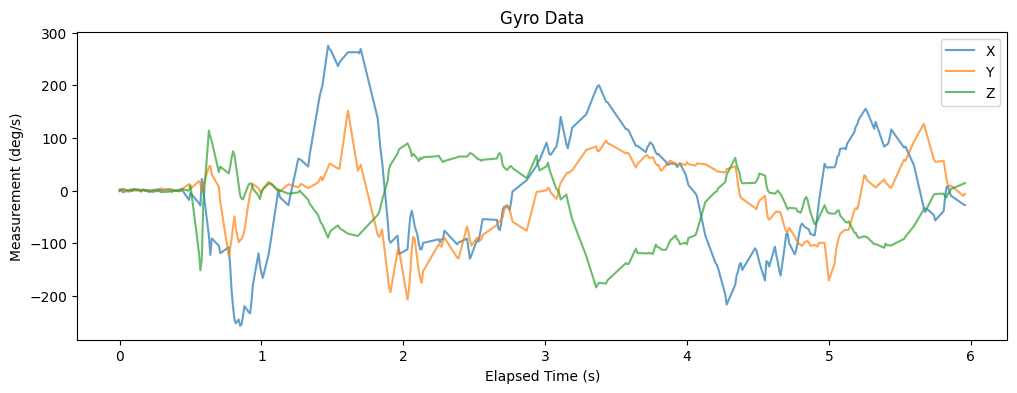

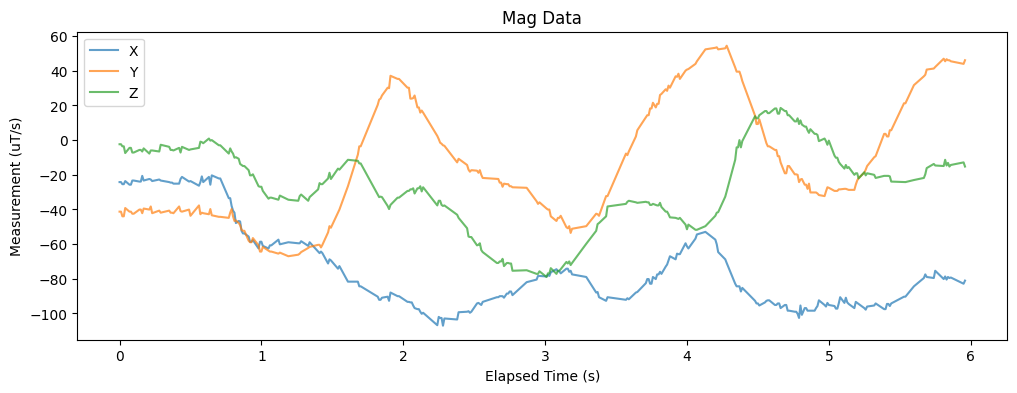

In [17]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 4))
plt.plot(planar['Elapsed'], planar['X'], label='X', alpha=0.7)
plt.plot(planar['Elapsed'], planar['Y'], label='Y', alpha=0.7)
plt.plot(planar['Elapsed'], planar['Z'], label='Z', alpha=0.7)
plt.title("Planar Data")
plt.xlabel('Elapsed Time (s)')
plt.ylabel('Measurement (m/s²)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(gyro['Elapsed'], gyro['X'], label='X', alpha=0.7)
plt.plot(gyro['Elapsed'], gyro['Y'], label='Y', alpha=0.7)
plt.plot(gyro['Elapsed'], gyro['Z'], label='Z', alpha=0.7)
plt.title("Gyro Data")
plt.xlabel('Elapsed Time (s)')
plt.ylabel('Measurement (deg/s)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(mag['Elapsed'], mag['X'], label='X', alpha=0.7)
plt.plot(mag['Elapsed'], mag['Y'], label='Y', alpha=0.7)
plt.plot(mag['Elapsed'], mag['Z'], label='Z', alpha=0.7)
plt.title("Mag Data")
plt.xlabel('Elapsed Time (s)')
plt.ylabel('Measurement (uT/s)')
plt.legend()
plt.show()

Copyright © 2025 Callum Mackenzie